In [1]:
import os
import sys

import pandas as pd

## First let's look at our dataset and determine how it should be split up

In [4]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [2]:
## Let's make a directory within datasets to store all our files
# Choose a short string 3-5 characters to denote this particular dataset
# For this one, I chose "ribo" for the ribosomal rna.
# Make sure to set "focus" in datatype as the same string

dataset_focus = "cov"
dataset_dir = f"./{dataset_focus}/"

if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

In [3]:
# Let's import our data_prep tools
import data_prep as dp

In [7]:
# The below code can take awhile to run depending on the size of each file
cov_df = dp.process_raw_fasta_files("r1.txt", "r2.txt", "r3.txt", "r4.txt", "r5.txt", "r6.txt", "r7.txt", "r8.txt", "r9.txt", "r10.txt", "r11.txt", "r12.txt", in_dir="/mnt/D1/sars-cov-2-data/processed/", out_dir=dataset_dir, violin_out="cov_data_lengths", input_format="fasta")

Observed Characters: ['C', 'A', 'N', 'G', 'T']


## Looking at the above graph + the length report in our out directory we see this

<img src="./cov/cov_data_lengths.png" alt="COV Data Lengths" style="height: 50px; width:50px;"/>

In [3]:
!cat ./cov/r5_len_report.txt

Removed 3036794 Repeat Sequences
Length: 19 Number of Sequences 1
Length: 25 Number of Sequences 2
Length: 27 Number of Sequences 2
Length: 28 Number of Sequences 2
Length: 29 Number of Sequences 6
Length: 30 Number of Sequences 29
Length: 31 Number of Sequences 59
Length: 32 Number of Sequences 74
Length: 33 Number of Sequences 108
Length: 34 Number of Sequences 125
Length: 35 Number of Sequences 286
Length: 36 Number of Sequences 546
Length: 37 Number of Sequences 1280
Length: 38 Number of Sequences 5464
Length: 39 Number of Sequences 12615
Length: 40 Number of Sequences 2078863
Length: 41 Number of Sequences 162432


In [ ]:
# So now we can define our datatype

# Datatype defines the basics of our data, Each datatype is specified for a group of related fasta files
# Focus - > short string specifier that gives the overall dataset we are using
# Molecule -> What kind of sequence data? currently protein, dna, and rna are supported
# id -> short string specifier ONLY for datasets which have different clustering methods (CLUSTERS ONLY)
# process -> How were the gaps added to each dataset, used to name directory (CLUSTERS ONLY)
# clusters -> How many clusters are in each data file (1 if no clusters)
# cluster_indices -> Define the lengths of data put in each cluster, It is inclusive so [12, 16] includes length 12 and length 16. There must be cluster_indices for each cluster
# gap_position_indices -> Index where gaps should be added to each sequence that is short of the maximum length. (-1 means add gaps to the end of the clusters)

cov_datatype = {"focus": "cov", "molecule": "dna", "id": None, "process": None, "clusters": 1, "gap_position_indices": [-1], "cluster_indices": [[40, 40]]}

## Before we do anything else, we need to copy our datatype to phage_display_ML/rbm_torch/global_info.py
## Also make sure to add the new datatype to the datatype_list in the same file.

## Next we need to process the raw files and make our own fasta files with our preferred formatting

In [7]:
# chars_to_remove = ["W", "D", "V", "M", "B", "R", "K", "Y", "H", "S"]
# chars_replace = {x: "-" for x in chars_to_remove}
dp.prepare_data_files("cov", cov_df, target_dir=dataset_dir, character_conversion={"T": "U", "N":"-"}, remove_chars=None) # Creates datafiles in target directory

## Now we have generated a data file that we can use for training our RBM or CRBM

#We will also try scaling the weights based off other information. In this case I am going choose a weight that is representative of both the copy number and the number of sequences that match with less than a threshold of difference b/t one another. To do this I'm going to read in the already processed files with their count number. And write them out with the altered weights in the fasta file

In [ ]:
import numpy as np

#### The Below Scaling Weights didn't work too well, returned about the same model as just the raw weights

In [ ]:
## Scaling all Rounds except R1 and R2 (way too much data, pairwise neighbor jobs aren't done yet)

In [3]:
fasta_file = "r3.fasta"
dp.scale_weights(f"./cov/{fasta_file}", "./cov/sw/", f"./cov/{fasta_file}_15_neighbor_counts.pkl", molecule="dna", threads=12, precision=20, scale_log=True, copynum_coeff=5.0, neighbor_coeff=0.5, normalize_threshold=0.75)

Process Time 0.587090015411377


In [4]:
sys.path.append("../rbm_torch/")
import rbm_torch.utils as utils
import data_prep as dp
import numpy as np

In [5]:
all_fasta_files = [f"r{i}.fasta" for i in range(3, 13)]
all_affinities =[]
min_vals = []
for fasta_file in all_fasta_files:
    seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_file}", "dna", threads=12)
    # stand_affs = dp.standardize_affinities(affs, out_plot=f"./cov/sw/{fasta_file.split('.')[0]}_stand_affs")
    stand_affs = dp.standardize_affinities(affs, out_plot=f"./cov/nw/{fasta_file.split('.')[0]}_stand_affs")
    min_vals.append(min(stand_affs))
    all_affinities.append(stand_affs)
    # neighs = dp.load_neighbor_file(f"./cov/{fasta_file}_15_neighbor_counts.pkl")
    # neighs_log_scaled = dp.scale_values_np(dp.log_scale(neighs, base=0.001), min=0.01, max=1.00)
    # dp.quick_hist(neighs_log_scaled.squeeze(1).tolist(), outfile=f"./cov/sw/{fasta_file.split('.')[0]}_neighs_log_scaled")
    # new_weights = np.asarray(stand_affs) * neighs_log_scaled.squeeze(1)
    # dp.quick_hist(new_weights.tolist(), outfile=f"./cov/sw/{fasta_file.split('.')[0]}_aff_and_neigh_weights")
    # dp.make_weight_file(f"./cov/nw/{fasta_file.split('.')[0]}_nw_weights", stand_affs, "nw")
    # dp.write_fasta(seqs, stand_affs, f"./cov/nw/{fasta_file}")
    # dp.write_fasta(seqs, new_weights.tolist(), f"./cov/sw/{fasta_file.split('.')[0]}_n")

Process Time 0.5592570304870605
Process Time 0.3178377151489258
Process Time 1.5709872245788574
Process Time 1.1642749309539795
Process Time 2.1850874423980713
Process Time 0.6264688968658447
Process Time 0.16741061210632324
Process Time 0.41866111755371094
Process Time 0.20952653884887695
Process Time 0.4487771987915039


In [6]:
thresholds = min_vals
for fid, fasta_file in enumerate(all_fasta_files):
    new_weights =dp.negate_affinites(all_affinities[fid], thresholds[fid], out_plot=f"./cov/nw/{fasta_file.split('.')[0]}_n3_affs", negative_factor=10000.)
    dp.make_weight_file(f"./cov/nw/{fasta_file.split('.')[0]}_n3_weights", new_weights, "n3")
    # dp.write_fasta(seqs, stand_affs, f"./cov/nw/{fasta_file}")

In [82]:
neighs = calc_neighbors(X, threshold=0.15)
o = open(f"{fasta_file}_pairwise_distances.txt", "w+")
o.write(neighs)
o.close()

0.006617928672809606 % done
0.013235857345619212 % done
0.01985378601842882 % done
0.026471714691238424 % done
0.03308964336404803 % done
0.03970757203685764 % done
0.04632550070966725 % done
0.05294342938247685 % done


KeyboardInterrupt: 

In [2]:
sys.path.append("../")
import rbm_torch.global_info as gi

In [12]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [4]:
gi.generate_dataset_file([f"r{i}.fasta" for i in range(1, 13)], gi.supported_datatypes["cov"], destination="./dataset_files/")

In [1]:
!cat "./dataset_files/cov.json"

{"data_files": {"1": ["r1.fasta", "r2.fasta", "r3.fasta", "r4.fasta", "r5.fasta", "r6.fasta", "r7.fasta", "r8.fasta", "r9.fasta", "r10.fasta", "r11.fasta", "r12.fasta"]}, "rounds": {"1": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9", "r10", "r11", "r12"]}, "model_names": {"1": ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9", "r10", "r11", "r12"]}, "local_model_dir": {"rbm": "/mnt/D1/globus/cov_trained_rbms/", "crbm": "/mnt/D1/globus/cov_trained_crbms/"}, "data_dir": "../../datasets/cov/", "server_model_dir": {"rbm": "datasets/cov/trained_rbms/", "crbm": "datasets/cov/trained_crbms/"}, "molecule": "dna", "configkey": {"1": "cov"}, "clusters": 1}

In [ ]:
# We're all set to run our models now, except for creating default configs for each dataset
# Here is an example one for crbm. It should be appended to crbm_configs.py and added to all_configs dictionary also in crbm_configs.py

thc_default_config = {"fasta_file": "",
          "v_num": 43,
          "q": 5,
          "molecule": "rna",
          "epochs": 100, # get's overwritten by training script anyway
          "seed": seed, # this is defined in the config file
          "batch_size": 10000, # can be raised or lowered depending on memory usage
          "mc_moves": 4,
          "lr": 0.006,
          "lr_final": None, # automatically set as lr * 1e-2
          "decay_after": 0.75,
          "loss_type": "free_energy",
          "sample_type": "gibbs",
          "sequence_weights": None,
          "optimizer": "AdamW",
          "weight_decay": 0.001,  # l2 norm on all parameters
          "l1_2": 25.0,
          "lf": 5.0,
          "ld": 10.0,
          "data_worker_num": 4
          }


In [1]:
# TO figure out the convolution topology we use some helper functions in crbm.py

# This function gives all convolutions that fully sample all visible units on the conv transpose for a given data size
from rbm_torch.utils import suggest_conv_size

# one hot encoded vector of input size (B x V X Q) is the input the CRBM uses
visible_num = 43 # V
q_states = 5 #Q
input_shape = (visible_num, q_states)
suggest_conv_size(input_shape, padding_max=2, dilation_max=1, stride_max=2)

Finding Whole Convolutions for Input with 43 inputs:
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 3, Stride: 2, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 3, Stride: 2, Dilation: 1, Padding: 1
Whole Convolution Found:

## My current line of thinking is that having a dilation > 1 or a stride > 1 will introduce some position specific effects.

In [ ]:
## Idea: The size of the kernel controls defines the size of the motif/pattern of the convolutional filter. So for this dataset I expect long filters to capture the secondary structure of this rfam family

# It is possible to use different strides and dilations, but I think they only take away from the interpretability of the convolutional filters. Also, they can lead to unsampled visible units on the convolution transpose. Likewise using a hidden layer with the kernel size the same as the number of visible units is somewhat equivalent to an RBM if not exactly (I haven't verified). This introduces a positional dependence into the corresponding hidden layer of the model.

# So I will use sizes:  11, 25, 46, 86, 100, 112
# Motif Finding:  Local Features-------Global Features
# Names/Keys for hidden layers in the convolutional topology can be named anything you can use as key in a dictionary
# Model outputs are the average of each hidden layer with a set weight
thc_default_config["convolution_topology"] = {"hidden10": {"number": 15, "kernel": (9, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden25": {"number": 15, "kernel": (17, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden46": {"number": 15, "kernel": (25, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden86": {"number": 15, "kernel": (33, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                             }

In [ ]:
### COPY THE ABOVE CELL TO CRBM CONFIGS AS WELL

In [ ]:
# Lets create a submission script for a slurm system to run by using the script submit.py

# Submission files are stored in rbm_torch/submission/

# From Directory rbm_torch I ran
"python submit.py -d cov -r all -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 --precision double"

# Use python submit.py -h for help!

In [2]:
# Merging rounds

import data_prep as dp
import rbm_torch.analysis.analysis_methods as am

cov_df = am.fetch_data(["r10", "r11", "r12"], dir="./cov/", threads=6, molecule="dna")

cov_ct = dp.copynum_topology_faster(cov_df, ["r10", "r11", "r12"], threads_per_task=3)
# cov_ct.to_csv("./cov/cov_10_to_12_ct.csv", index=False)

Process Time 0.549140214920044
Process Time 0.2518928050994873
Process Time 0.5835025310516357


KeyboardInterrupt: 

In [3]:
cov_ct.head()

,sequence,r10,r11,r12
0,GGGATATTCGTCCGGGGGGGGGGCCGGGGTTCGGGGTCGT,1.0,NaN,2.0
1,GGTGGGGGGCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC,26.0,21.0,20.0
2,GGGGGGGCGCCCCCCCGGTTCTCGCTGCTGGTTTTGGTGC,5.0,1.0,3.0
3,CGGGTTTCCGTCTGGGGGGGGGGCCGGGGTGGGGGGTCGT,1.0,1.0,2.0
4,TCGCGGGGGGCGAGTCGGGTGCTCGTTCGAGGGGTCACAG,34.0,11.0,18.0


In [4]:
import pandas as pd
import numpy as np
cov_ct = pd.read_csv("./cov/cov_10_to_12_ct.csv")
cov_ct["mean"] = cov_ct.apply(lambda row : np.nanmean(np.asarray([row[x] for x in ["r10", "r11", "r12"]])), axis=1)
cov_ct["max"] = cov_ct.apply(lambda row : np.nanmax(np.asarray([row[x] for x in ["r10", "r11", "r12"]])), axis=1)

In [11]:
ones = cov_ct[cov_ct["mean"] >= 2.0]
max = cov_ct[cov_ct["max"] >= 15.0]
ones_max = ones[ones["max"] >= 6]
print(ones.index.__len__(), ones_max.index.__len__(), max.index.__len__())

94881 46632 19707


In [9]:
max.sort_values("max", ascending=False, inplace=True)
max.head(30)

<ipython-input-9-cda033640aa7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max.sort_values("max", ascending=False, inplace=True)


,sequence,r10,r11,r12,mean,max
189499,GGGAGGGAGGGTGGGGGGTTCTCGCTGCGGGTTTTGGTGC,1122103.0,425460.0,780426.0,775996.333333,1122103.0
142400,GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAACT,847457.0,320078.0,555261.0,574265.333333,847457.0
39726,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT,170289.0,140742.0,650339.0,320456.666667,650339.0
175303,TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG,108596.0,103763.0,486834.0,233064.333333,486834.0
47658,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT,112090.0,88184.0,445204.0,215159.333333,445204.0
70642,AGGCTTATCGTCAGGGGGGTGGGTCCGGGTTCGGGGTCGT,317062.0,113679.0,261269.0,230670.000000,317062.0
56773,GCCACGCCGGCTTCGGGGGGTGGGATGGGTTCGGGGTCCT,23778.0,33603.0,220812.0,92731.000000,220812.0
182008,GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAGCT,93099.0,53982.0,146539.0,97873.333333,146539.0
176095,GGGGGGGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,114896.0,32291.0,90650.0,79279.000000,114896.0
156970,GGGGGGGGGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,111390.0,35664.0,90127.0,79060.333333,111390.0


In [12]:
dp.dataframe_to_fasta(max, "m1.fasta", count_key="max")

In [18]:
## Create Neighbor Job
!python ./submit_neighbor_job.py -h

usage: submit_neighbor_job.py [-h] -d DATADIR -f FASTAFILE [FASTAFILE ...] -m
                              MOLECULE -o OUT -t1 T1 -t2 T2 [-c [C]]

Generate Slurm Files for pytorch RBM and CRBM

optional arguments:
  -h, --help            show this help message and exit
  -c [C]                Number of CPU cores to use. Default is 6.

required named arguments:
  -d DATADIR, --datadir DATADIR
                        directory of fasta file
  -f FASTAFILE [FASTAFILE ...], --fastafile FASTAFILE [FASTAFILE ...]
                        fasta file
  -m MOLECULE, --molecule MOLECULE
                        Which molecule?
  -o OUT, --out OUT     File Name for generated sbatch file
  -t1 T1                1st threshold value
  -t2 T2                2nd threshold value


In [20]:
# length of seqs is 40 nucleotides on avg. SO threshold values correspond to 2 mutations away and 4 mutations away
!python ./submit_neighbor_job.py -d cov -f m1.fasta -m dna -o cov_m1_neigh -t1 0.05 -t2 0.10 -c 24

In [5]:
m1_neighs = dp.load_neighbor_file("./cov/m1.fasta_5_neighbor_counts.pkl")

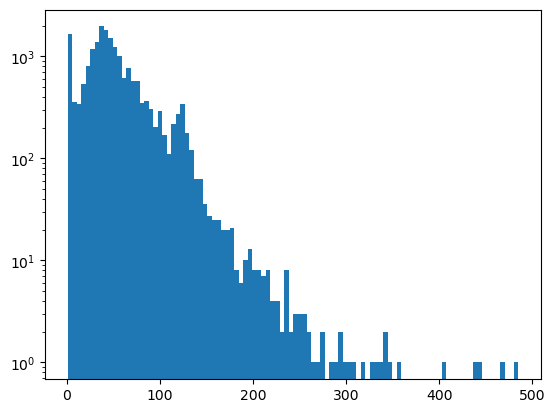

In [6]:
dp.quick_hist(m1_neighs)

Process Time 0.02819538116455078


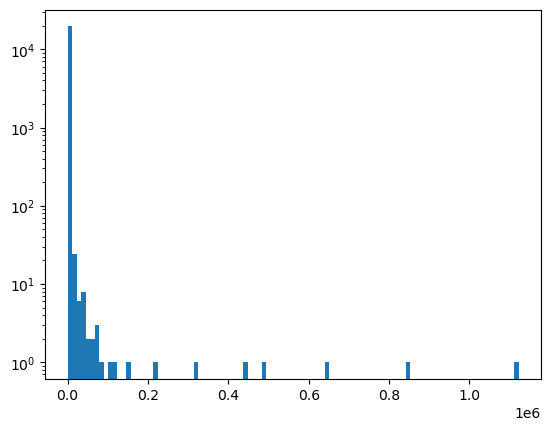

In [7]:
import rbm_torch.utils.utils as utils

seqs, affs, chars, q  = utils.fasta_read("./cov/m1.fasta", "dna", threads=6)
dp.quick_hist(affs)

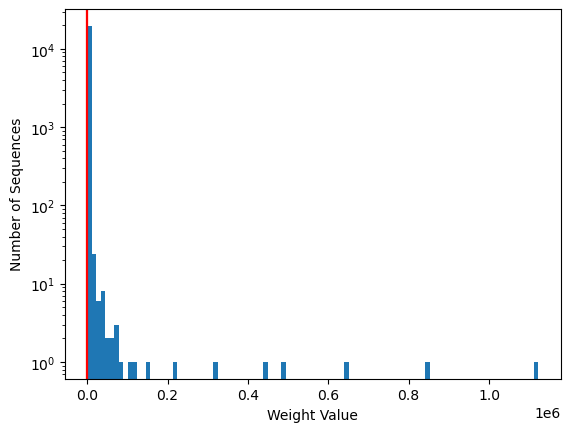

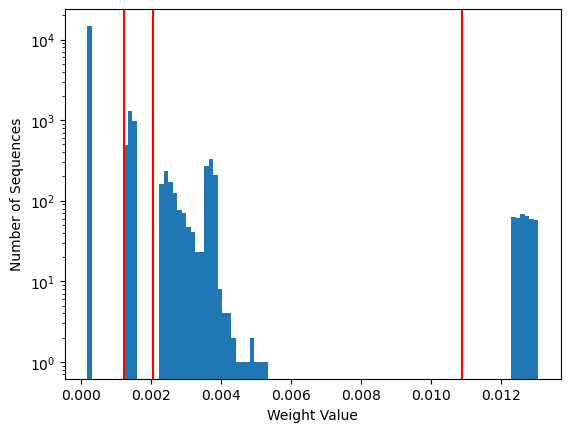

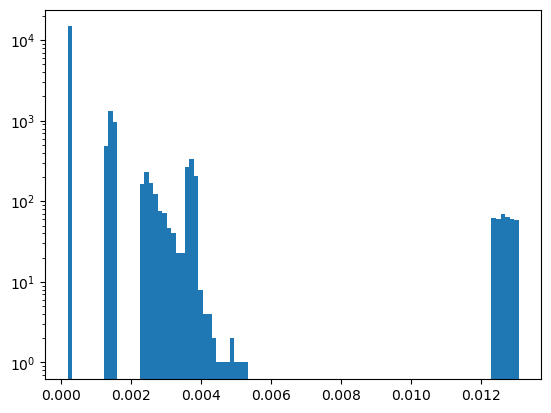

In [10]:
naffs = dp.standardize_affinities(affs, out_plots="./cov/m1_stand", scale="log", dividers=[5, 15, 25], target_scaling=[1.2, 1.2, 1.2], divider_type="percentile")
dp.quick_hist(naffs)

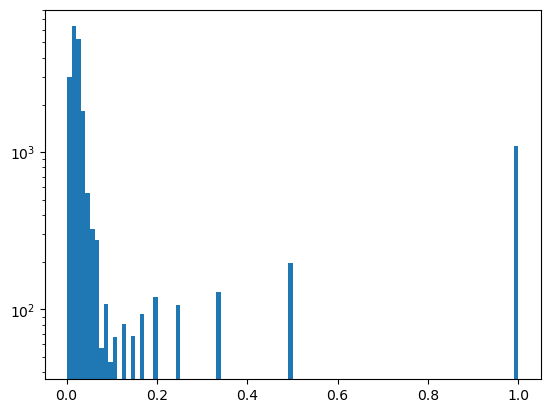

In [12]:
inverse_m1_neighs = [1/x for x in m1_neighs]
dp.quick_hist(inverse_m1_neighs)

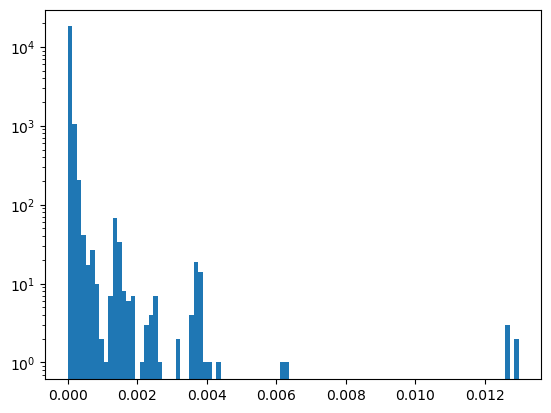

In [14]:
test_scaling = [naffs[xid]* x for xid, x in enumerate(inverse_m1_neighs)]
dp.quick_hist(test_scaling)

In [15]:
dp.make_weight_file("m1_co", test_scaling, "co", dir="./cov/")

In [16]:
import subprocess as sp
os.chdir("../rbm_torch/")


FileNotFoundError: [Errno 2] No such file or directory: 'python submit.py -h'

In [24]:
os.getcwd()
!python submit.py -h

usage: submit.py [-h] -d DATATYPE -r ROUND -p PARTITION -q QUEUE -m MODEL -e
                 EPOCHS -g GPUS [--wdir [WDIR]] [--precision PRECISION]
                 [-c [C]] [-w [W]] [--walltime [WALLTIME]] [-a [ACCOUNT]]
                 [--email [EMAIL]] [--error [ERROR]]

Generate Slurm Files for pytorch RBM and CRBM

optional arguments:
  -h, --help            show this help message and exit
  --wdir [WDIR]         Manually Set working directory, Usually handled
                        internally.
  --precision PRECISION
                        Set precision of the model, single or double
  -c [C]                Number of CPU cores to use. Default is 6.
  -w [W]                Weight File name to use to weight model training. Must
                        be in same directory as the sequence files.
                        Alternatively can be 'fasta' or None
  --walltime [WALLTIME]
                        Set wall time for training
  -a [ACCOUNT], --account [ACCOUNT]
              

In [ ]:
# I manually added m1.fasta to the dataset file
# Also manually copied weight file to the server

In [25]:
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2", shell=True) # no weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 -w m1_co.json", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m rbm -e 200 -g 1", shell=True) # no weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m rbm -e 200 -g 1 -w m1_co.json", shell=True) # weights

0

## The Neighbor Reweighting did not help, the model still overfit to a particular sequence motif.

In [10]:
################## Neighbor Only Reweighting
import numpy as np
m1_close_neighs = dp.load_neighbor_file("./cov/m1.fasta_5_neighbor_counts.pkl")
m1_far_neighs = dp.load_neighbor_file("./cov/m1.fasta_10_neighbor_counts.pkl")

neigh_avg = np.asarray(m1_close_neighs)+np.asarray(m1_far_neighs)/2

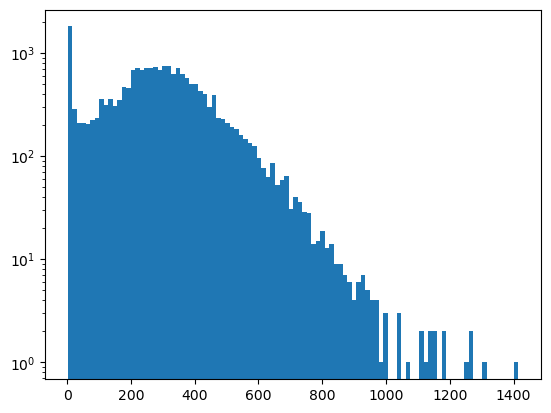

In [11]:
dp.quick_hist(neigh_avg)

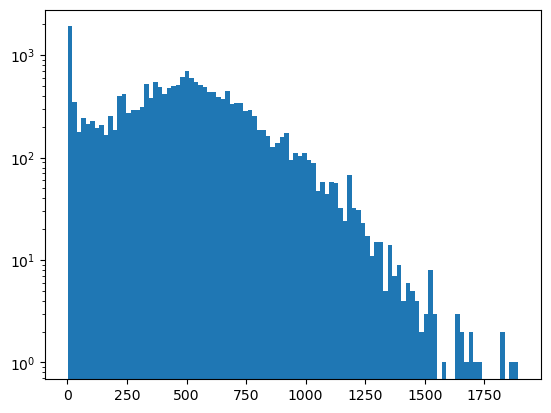

In [8]:
dp.quick_hist(m1_far_neighs)

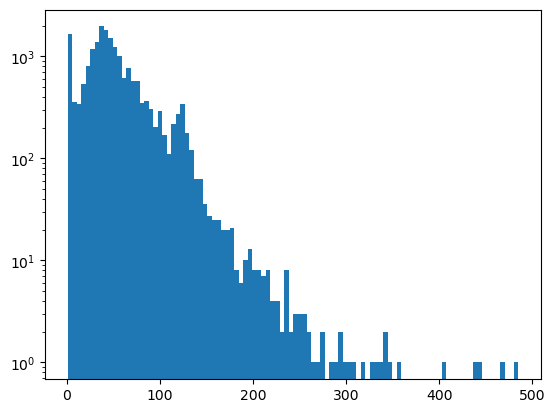

In [9]:
dp.quick_hist(m1_close_neighs)

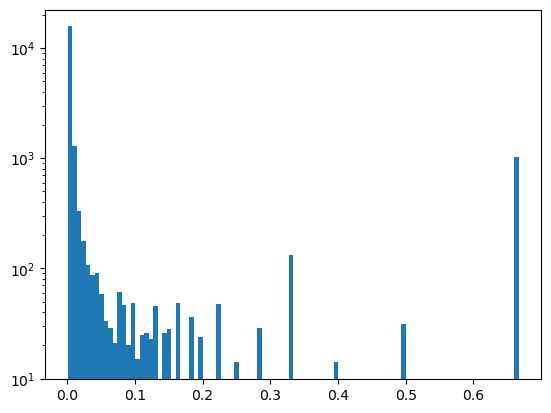

In [12]:
dp.quick_hist(1/neigh_avg)

In [14]:
dp.make_weight_file("m1_ne", (1/neigh_avg).tolist(), "ne", dir="./cov/")

In [17]:
import subprocess as sp
import os
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 -w m1_ne.json", shell=True) # weights

0

## After Separating based off PCA/kmeans, I am now training models on the individual clusters picked out from there

In [21]:
os.chdir("../datasets/")

Process Time 0.0038704872131347656


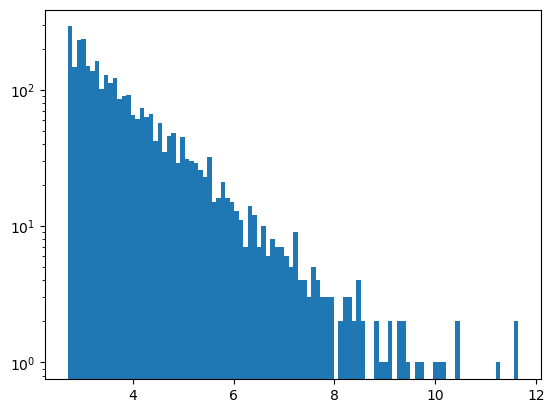

Process Time 0.006558895111083984


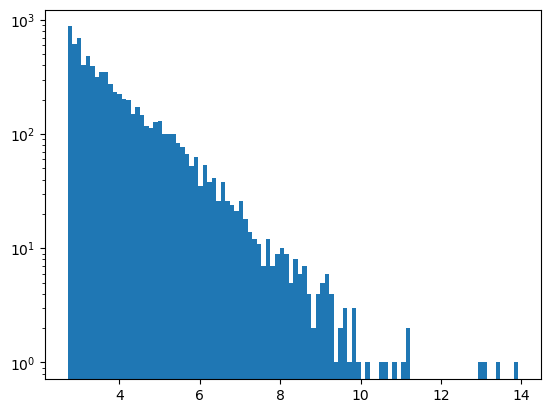

Process Time 0.00397801399230957


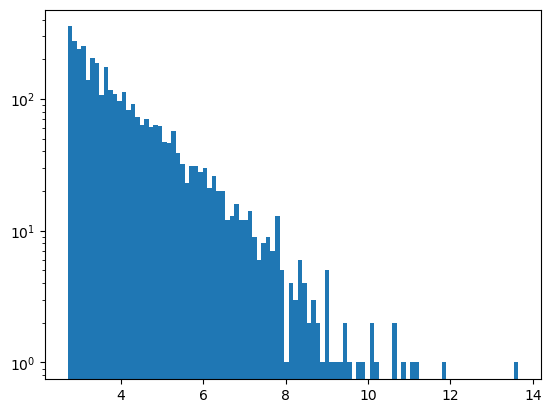

Process Time 0.004990816116333008


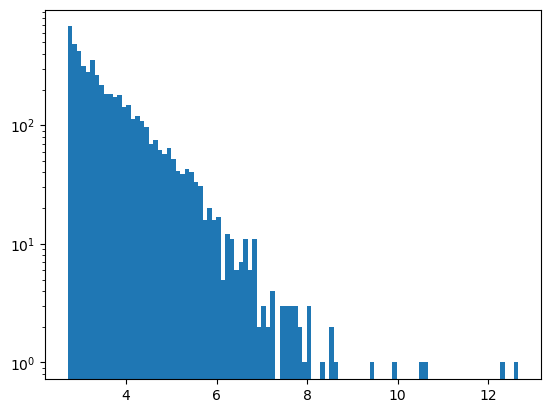

In [23]:
## Weighting by affinity for each of these files
import rbm_torch.utils.utils as utils

all_fasta_files = [f"m1_s{i}.fasta" for i in range(1, 5)]
for fasta_file in all_fasta_files:
    seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_file}", "dna", threads=12)
    naffs = dp.log_scale(affs, base=0.001)
    # naffs = dp.standardize_affinities(affs, scale="log", dividers=[40, 70], target_scaling=[2., 1.5])
    dp.quick_hist(naffs)
    dp.make_weight_file(f"{fasta_file.split('.')[0]}_sw", naffs.tolist(), "sw", dir="./cov/")

In [25]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/rbm_torch'

In [27]:
import subprocess as sp
import os
# os.chdir("../rbm_torch/")
fasta_base = [f"m1_s{i}" for i in range(1, 5)]
weight_files = [f"m1_s{i}_sw.json" for i in range(1, 5)]
for fid, f in enumerate(fasta_base):
    sp.check_call(f"python submit.py -d cov -r {f} -p wzhengpu1 -q wildfire -m crbm -e 200 -g 1 -w {weight_files[fid]} --precision single", shell=True) # weights

In [4]:
########## Make an m1c file (Smaller subset than the m1 file)
os.chdir("../rbm_torch/")
import rbm_torch.analysis.analysis_methods as am
os.chdir("../datasets/")
m1_data = am.fetch_data(["m1"], dir="./cov/", threads=12, molecule="dna")

Process Time 0.01757359504699707


In [9]:
from copy import copy
m1c_data = copy(m1_data[m1_data["copy_num"] >= 200])  #.index.__len__()  # 2136 seqs.

import data_prep as dp
dp.dataframe_to_fasta(m1c_data, "./cov/m1c.fasta")

In [20]:
import numpy as np
import math
from rbm_torch.utils import utils


# fasta_files = ["m1c.fasta", "m1.fasta"]
fasta_ids = ["m1c", "m1"]

for fasta_id in fasta_ids:
    close_neighs = dp.load_neighbor_file(f"./cov/{fasta_id + '.fasta'}_10_neighbor_counts.pkl")
    far_neighs = dp.load_neighbor_file(f"./cov/{fasta_id + '.fasta'}_20_neighbor_counts.pkl")

    neigh_avg = (np.asarray(close_neighs)+np.asarray(far_neighs))/2
    neigh_vals = 1. + 1./neigh_avg
    neigh_exp_vals = np.exp(neigh_vals) - math.e


    seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_id + '.fasta'}", "dna", threads=12)
    if fasta_id == "m1c":
        stand_affs = dp.standardize_affinities(affs, out_plots=f"./cov/{fasta_id}_st", scale="log", dividers=[70], target_scaling=[2.], divider_type="percentile")
    elif fasta_id == "m1":
        stand_affs = dp.standardize_affinities(affs, out_plots=f"./cov/{fasta_id}_st", scale="log", dividers=[70], target_scaling=[2.], divider_type="percentile")


    dp.make_weight_file(f"{fasta_id}_nexp", neigh_exp_vals.tolist(), "nexp", dir="./cov/")
    dp.make_weight_file(f"{fasta_id}_ne", neigh_vals.tolist(), "ne", dir="./cov/")
    dp.make_weight_file(f"{fasta_id}_st", neigh_vals.tolist(), "st", dir="./cov/")
    dp.make_weight_file(f"{fasta_id}_stne", (neigh_vals*stand_affs).tolist(), "stne", dir="./cov/")
    dp.make_weight_file(f"{fasta_id}_stnexp", (neigh_exp_vals*stand_affs).tolist(), "stnexp", dir="./cov/")

Process Time 0.0036449432373046875
Process Time 0.015247106552124023


In [22]:
import subprocess as sp
import os
os.chdir("../rbm_torch/")
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_nexp.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_ne.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_st.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_stne.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1 -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 2 -w m1_stnexp.json --precision single", shell=True) # weights

sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_nexp.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_ne.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_st.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_stne.json --precision single", shell=True) # weights
sp.call(f"python submit.py -d cov -r m1c -p wzhengpu1 -q wildfire -m crbm -e 2000 -g 1 -w m1_stnexp.json --precision single", shell=True) # weights

0